<a href="https://colab.research.google.com/github/suri199507/image_processing_deep-learning/blob/master/CNNmodel_tranning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth() 
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
download = drive.CreateFile({'id':'1i6Jj9RUTluqTAxrMcr95C_oYKem4589Z'})
download.GetContentFile('model_data.zip')


In [0]:
!ls

adc.json		GroceryDataset_part1_1.zip  model_data.zip
GroceryDataset_part1_1	model_data		    sample_data


In [0]:
!unzip model_data.zip


In [0]:
download = drive.CreateFile({'id':'1xepetD5kn2PbwE6hSPcFeTyuHtkEKuPI'})
download.GetContentFile('GroceryDataset_part1_1.zip')


In [0]:
!unzip --qq GroceryDataset_part1_1

In [0]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import pandas as pd
import cv2
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
from keras.layers import Dense, Dropout, Activation, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import BatchNormalization
from keras.regularizers import l2
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
from keras import backend as K


%matplotlib inline

Using TensorFlow backend.


In [0]:
shelf_images_train = 'GroceryDataset_part1_1/ShelfImages/ShelfImages/train/'

In [0]:

photos_df = pd.read_pickle(f'model_data/photos.pkl')
products_df =  pd.read_pickle(f'model_data/products.pkl')

In [0]:
 #neural networks work with input of fixed size, so we need to resize our
# packs images to the chosen size. The size is some kind of metaparameter and 
# you should try different variants. Logically, the bigger size you select,
# the better performace you'll have. Unfortunatelly it is not true, because 
# of over fitting. The more parameters your neural network have, the easier it
# became over fitted
num_classes = 10
SHAPE_WIDTH = 80
SHAPE_HEIGHT = 120

In [0]:
# resize pack to fixed size SHAPE_WIDTH x SHAPE_HEIGHT
def resize_pack(pack):
    fx_ratio = SHAPE_WIDTH / pack.shape[1]
    fy_ratio = SHAPE_HEIGHT / pack.shape[0]    
    pack = cv2.resize(pack, (0, 0), fx=fx_ratio, fy=fy_ratio)
    return pack[0:SHAPE_HEIGHT, 0:SHAPE_WIDTH]

In [0]:
x,y,f=[],[],[]
for file, is_train in photos_df[['file', 'is_train']].values:
  photo_r=products_df[products_df.file==file]
  r_data=photo_r[['category', 'xmin', 'ymin', 'xmax', 'ymax']]
  img=cv2.imread(f'{shelf_images_train}{file}')
  img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  for category, xmin, ymin, xmax, ymax in r_data.values:
        if category == 0:
            continue
        pack = resize_pack(np.array(img[ymin:ymax, xmin:xmax]))
        x.append(pack)
        f.append(is_train)
        y.append(category - 1)

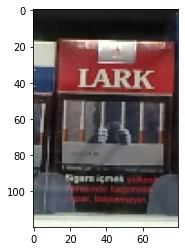

In [0]:
# display one SHAPE_WIDTH x SHAPE_HEIGHT resized pack image, 
# it is hard to recognize category with our eyes, let's see
# how neural network will do the job
plt.imshow(x[60])

In [0]:
x = np.array(x)
y = np.array(y)
f = np.array(f)
x_train, x_validation, y_train, y_validation = x[f], x[~f], y[f], y[~f]
# save validation images
x_validation_images = x_validation

In [0]:
# convert y_train and y_validation to one-hot arrays
y_train = keras.utils.to_categorical(y_train, num_classes)
y_validation = keras.utils.to_categorical(y_validation, num_classes)

In [0]:
# normalize x_train, x_validation
x_train = x_train.astype('float32')
x_validation = x_validation.astype('float32')
x_train /= 255
x_validation /= 255

In [0]:
# let's see what do we have
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print(x_train.shape[0], 'train samples')
print(x_validation.shape[0], 'validation samples')

x_train shape: (1508, 120, 80, 3)
y_train shape: (1508, 10)
1508 train samples
611 validation samples


In [0]:
# let's build our ResNet CNN. We don't do any significant changes to keras example
def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 5:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr
    

In [0]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x
def resnet_v1(input_shape, depth, num_classes=10):
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=x_train.shape[1:])
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

n = 3
version = 1
if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2
model_type = 'ResNet%dv%d' % (depth, version)

model = resnet_v1(input_shape=x_train.shape[1:], depth=depth, num_classes=num_classes)
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=lr_schedule(0)), metrics=['accuracy'])


Learning rate:  0.001


In [0]:
# This will do preprocessing and realtime data augmentation:
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=5,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=False,  # randomly flip images
    vertical_flip=False)  # randomly flip images
datagen.fit(x_train)

In [0]:
# let's run training process, 20 epochs is enough
batch_size = 50
epochs = 15
model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                    validation_data=(x_validation, y_validation),
                    epochs=epochs, verbose=1, workers=4, 
                    callbacks=[LearningRateScheduler(lr_schedule)])

Epoch 1/15
Learning rate:  0.001
31/31 [==============================] - 17s 545ms/step - loss: 1.6753 - accuracy: 0.6021 - val_loss: 24.7224 - val_accuracy: 0.0327
Epoch 2/15
Learning rate:  0.001
31/31 [==============================] - 5s 171ms/step - loss: 0.5454 - accuracy: 0.8800 - val_loss: 1.6322 - val_accuracy: 0.5466
Epoch 3/15
Learning rate:  0.001
31/31 [==============================] - 5s 149ms/step - loss: 0.3898 - accuracy: 0.9377 - val_loss: 1.4163 - val_accuracy: 0.6236
Epoch 4/15
Learning rate:  0.001
31/31 [==============================] - 5s 171ms/step - loss: 0.3327 - accuracy: 0.9542 - val_loss: 2.6334 - val_accuracy: 0.3159
Epoch 5/15
Learning rate:  0.001
31/31 [==============================] - 5s 150ms/step - loss: 0.2880 - accuracy: 0.9662 - val_loss: 1.1535 - val_accuracy: 0.6890
Epoch 6/15
Learning rate:  0.001
31/31 [==============================] - 5s 153ms/step - loss: 0.2557 - accuracy: 0.9748 - val_loss: 1.2817 - val_accuracy: 0.7054
Epoch 7/15
Lea

In [0]:
# let's estimate our result
scores = model.evaluate(x_validation, y_validation, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

611/611 [==============================] - 1s 943us/step
Test loss: 0.4570042278050596
Test accuracy: 0.929623544216156


In [0]:
#let see the how the classes are classified 
def plot_confusion_matrix(cm,classes,normalize=False,
                          title='Confusion matrix', cmap=plt.cm.Blues):
  if normalize :
     cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  plt.imshow(cm,interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd '
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
                horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "red")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')


In [0]:
# let's draw confusion matrix to check classes recognition performance
y_validation_cls = np.argmax(y_validation, axis=1)
y_validation_predict = model.predict(x_validation)
y_validation_predict_cls = np.argmax(y_validation_predict, axis=1)

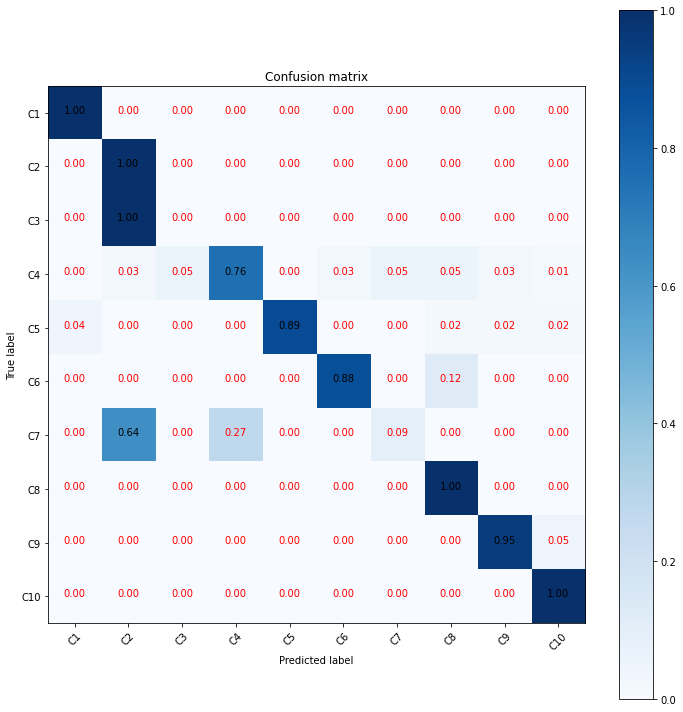

In [0]:
fig = plt.gcf()
fig.set_size_inches(10, 10)
cnf_matrix = confusion_matrix(y_validation_cls, y_validation_predict_cls)
plot_confusion_matrix(cnf_matrix, [f'C{i+1}' for i in range(num_classes)], 
                      title='Confusion matrix', normalize=True)

In [0]:
power = np.array([y_validation_predict[i][y_validation_predict_cls[i]] 
                  for i in range(len(y_validation_predict_cls))])


margin = 5
width = num_classes * SHAPE_WIDTH + (num_classes - 1) * margin
height = num_classes * SHAPE_HEIGHT + (num_classes - 1) * margin
confusion_image = np.zeros((height, width, 3), dtype='i')
for i in range(num_classes):
    for j in range(num_classes):
        flags = [(y_validation_cls == i) & (y_validation_predict_cls == j)]
        if not np.any(flags):
            continue
        max_cell_power = np.max(power[flags])
        index = np.argmax(flags & (power == max_cell_power))
        ymin, xmin = (SHAPE_HEIGHT+margin) * i, (SHAPE_WIDTH+margin) * j
        ymax, xmax = ymin + SHAPE_HEIGHT, xmin + SHAPE_WIDTH
        confusion_image[ymin:ymax, xmin:xmax, :] = x_validation_images[index]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  


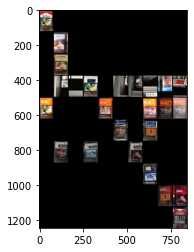

In [0]:
ig = plt.gcf()
fig.set_size_inches(20, 20)
plt.imshow(confusion_image)